In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import streamlit as st

# ============================================================
# 1. CHARGEMENT DES DEUX FEUILLES
# ============================================================

df_09_10 = pd.read_excel("../data/online_retail_II.xlsx", sheet_name="Year 2009-2010")
df_10_11 = pd.read_excel("../data/online_retail_II.xlsx", sheet_name="Year 2010-2011")

# Dataset fusionné pour l'exploration globale
df_all = pd.concat([df_09_10, df_10_11], ignore_index=True)

print("Feuille 2009-2010 :", df_09_10.shape)
print("Feuille 2010-2011 :", df_10_11.shape)
print("Concaténé :", df_all.shape)
print("-" * 60)


# ============================================================
# 2. FICHE SYNTHÉTIQUE (sur le dataset concaténé)
# ============================================================

df = df_all  # pour réutiliser ton code sans tout réécrire

print("===  FICHE SYNTHÉTIQUE (Dataset Concaténé) ===\n")
print(f"Source : Online Retail II - UCI Machine Learning Repository")
print(f"Période couverte : {df['InvoiceDate'].min()} → {df['InvoiceDate'].max()}")
print(f"Taille du Dataset : {df.shape}")
print(f"Volume total de lignes : {len(df):,}")
print(f"Colonnes : {', '.join(df.columns)}")
print("-" * 50)


# ============================================================
# 3. ANALYSE DES DONNÉES
# ============================================================

# Pourcentage de valeurs manquantes par colonne
missing = df.isna().mean().sort_values(ascending=False) * 100
missing = missing[missing > 0]
print("Pourcentage de valeurs manquantes (%) :")
print(missing)
print("-" * 50)

# Nombre de doublons exacts
duplicates = df.duplicated().sum()
print(f"Nombre de doublons exacts : {duplicates}")
print("-" * 50)

# Nombre de factures annulées
canceled = df['Invoice'].astype(str).str.startswith('C', na=False).sum()
total = len(df)
print(f"Factures annulées : {canceled} ({canceled/total:.2%} du total)")
print("-" * 50)

# Délai moyen entre deux transactions
df['diff'] = df['InvoiceDate'].sort_values().diff().dt.total_seconds().dropna()
print("Délai moyen entre deux transactions (secondes) :", round(df['diff'].mean(), 2))
print("-" * 50)

# Analyse des valeurs extrêmes (outliers)
for col in ['Quantity', 'Price']:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    nb_outliers = len(outliers)
    pct_outliers = nb_outliers / len(df) * 100

    print(f"{col} → {nb_outliers:,} valeurs extrêmes détectées ({pct_outliers:.2f} %)")
    print(f"Seuils : [{lower_bound:.2f}, {upper_bound:.2f}]")
    print("-" * 50)

Feuille 2009-2010 : (525461, 8)
Feuille 2010-2011 : (541910, 8)
Concaténé : (1067371, 8)
------------------------------------------------------------
===  FICHE SYNTHÉTIQUE (Dataset Concaténé) ===

Source : Online Retail II - UCI Machine Learning Repository
Période couverte : 2009-12-01 07:45:00 → 2011-12-09 12:50:00
Taille du Dataset : (1067371, 8)
Volume total de lignes : 1,067,371
Colonnes : Invoice, StockCode, Description, Quantity, InvoiceDate, Price, Customer ID, Country
--------------------------------------------------
Pourcentage de valeurs manquantes (%) :
Customer ID    22.766873
Description     0.410541
dtype: float64
--------------------------------------------------
Nombre de doublons exacts : 34335
--------------------------------------------------
Factures annulées : 19494 (1.83% du total)
--------------------------------------------------
Délai moyen entre deux transactions (secondes) : 59.76
--------------------------------------------------
Quantity → 116,489 valeurs

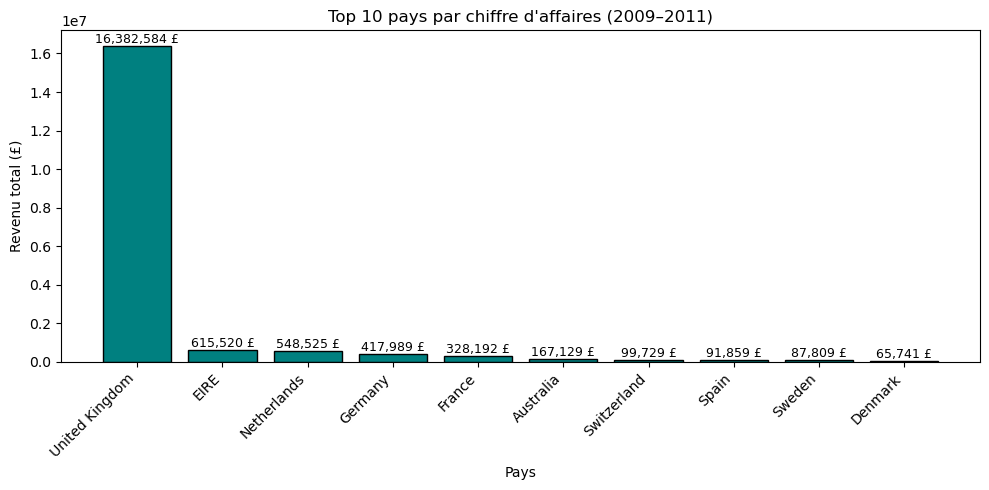

In [15]:
# ============================================================
# 📊 TOP 10 PAYS PAR CHIFFRE D’AFFAIRES (Dataset global = df)
# ============================================================

# Calcul du CA total
df['TotalPrice'] = df['Quantity'] * df['Price']

# Top 10 pays par CA
country_sales = (
    df.groupby('Country')['TotalPrice']
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

# Création du graphique
plt.figure(figsize=(10,5))
bars = plt.bar(country_sales.index, country_sales.values,
               color='teal', edgecolor='black')

# Titres et axes
plt.title("Top 10 pays par chiffre d'affaires (2009–2011)")
plt.ylabel("Revenu total (£)")
plt.xlabel("Pays")
plt.xticks(rotation=45, ha='right')

# Ajout des labels sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:,.0f} £",
        ha='center', va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()

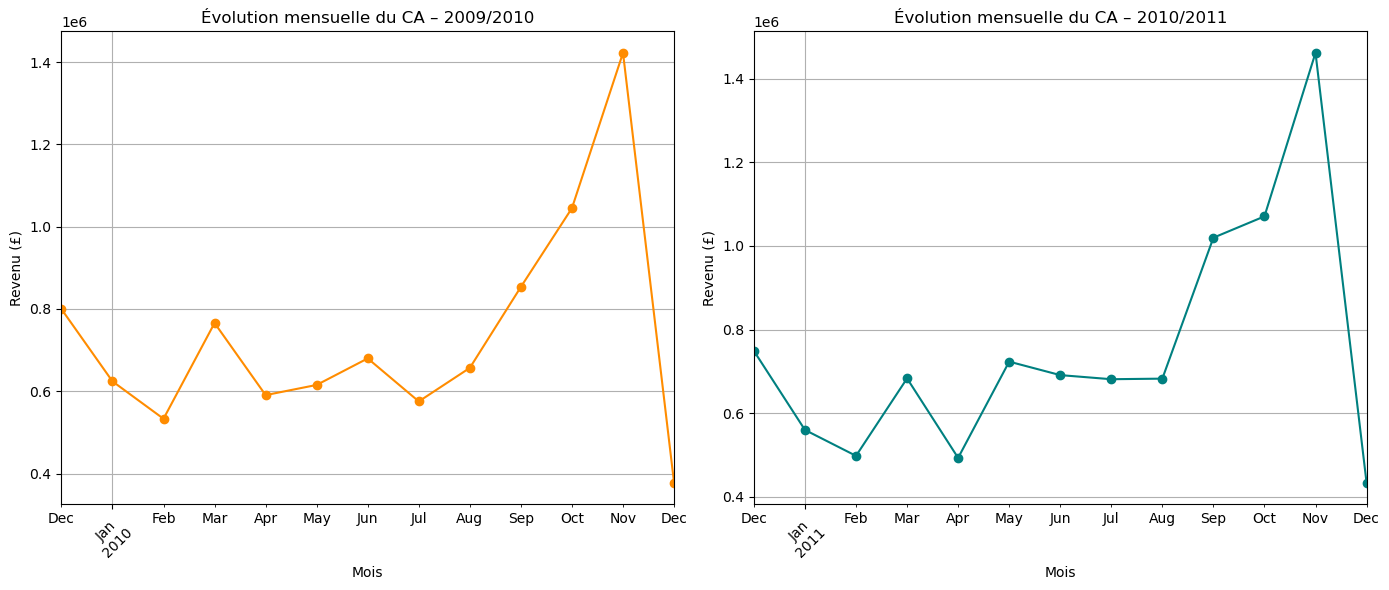

In [16]:
# Assurer format datetime
df_09_10['InvoiceDate'] = pd.to_datetime(df_09_10['InvoiceDate'])
df_10_11['InvoiceDate'] = pd.to_datetime(df_10_11['InvoiceDate'])

# Ajouter TotalPrice si pas déjà fait
df_09_10['TotalPrice'] = df_09_10['Quantity'] * df_09_10['Price']
df_10_11['TotalPrice'] = df_10_11['Quantity'] * df_10_11['Price']

# Revenus mensuels pour chaque année
rev_09_10 = df_09_10.groupby(df_09_10['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum()
rev_10_11 = df_10_11.groupby(df_10_11['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum()

# =====================================================
# 📊 DOUBLE GRAPHIQUE – Revenus mensuels par année
# =====================================================

plt.figure(figsize=(14,6))

# --- Graphe 1 : 2009–2010 ---
plt.subplot(1, 2, 1)
rev_09_10.plot(marker='o', color='darkorange')
plt.title("Évolution mensuelle du CA – 2009/2010")
plt.ylabel("Revenu (£)")
plt.xlabel("Mois")
plt.grid(True)
plt.xticks(rotation=45)

# --- Graphe 2 : 2010–2011 ---
plt.subplot(1, 2, 2)
rev_10_11.plot(marker='o', color='teal')
plt.title("Évolution mensuelle du CA – 2010/2011")
plt.ylabel("Revenu (£)")
plt.xlabel("Mois")
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

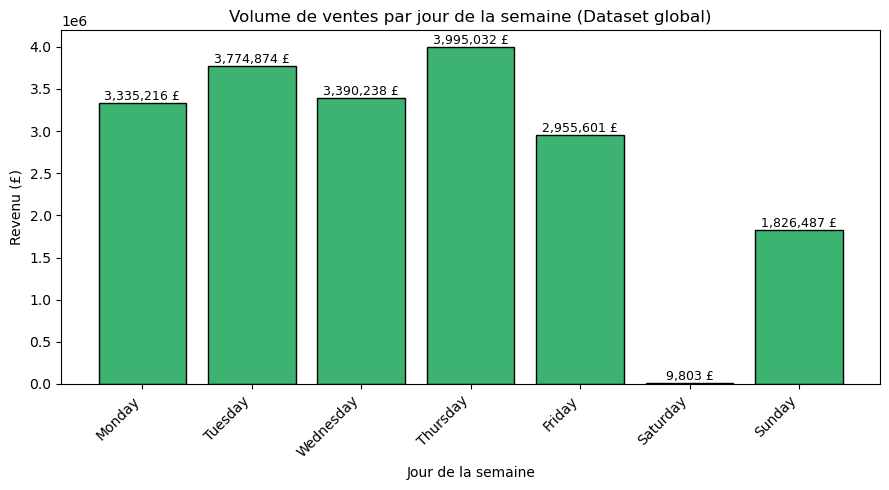

In [25]:
# Création de la colonne weekday (déjà en datetime → OK)
df['weekday'] = df['InvoiceDate'].dt.day_name()

# Ordre logique des jours
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# CA par jour de la semaine
weekday_sales = (
    df.groupby('weekday')['TotalPrice']
      .sum()
      .reindex(order)
)

# Graphique global
plt.figure(figsize=(9,5))
bars = plt.bar(weekday_sales.index, weekday_sales.values, 
               color='mediumseagreen', edgecolor='black')

plt.title("Volume de ventes par jour de la semaine (Dataset global)")
plt.ylabel("Revenu (£)")
plt.xlabel("Jour de la semaine")
plt.xticks(rotation=45, ha='right')

# ➤ Ajout des labels sur chaque barre
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:,.0f} £",   # format avec séparateur de milliers
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

plt.tight_layout()
plt.show()

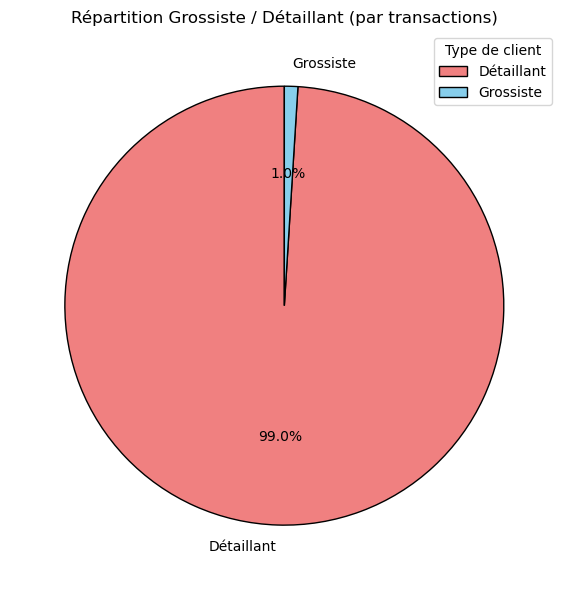

In [18]:
# Classification simple en fonction de la quantité commandée
df['client_type'] = df['Quantity'].apply(
    lambda x: 'Grossiste' if x > 100 else 'Détaillant'
)

# Comptage des types de transactions
type_counts = df['client_type'].value_counts()

# Graphique camembert
plt.figure(figsize=(6,6))
type_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightcoral', 'skyblue'],
    wedgeprops={'edgecolor':'black'}
)

plt.title("Répartition Grossiste / Détaillant (par transactions)")
plt.ylabel("")  # enlève le label "client_type"
plt.legend(title="Type de client")
plt.tight_layout()
plt.show()

/var/folders/jd/v8lrdfvd3ng088d3mghgymph0000gn/T/ipykernel_38365/371134019.py:50: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128722 (\N{SHOPPING TROLLEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


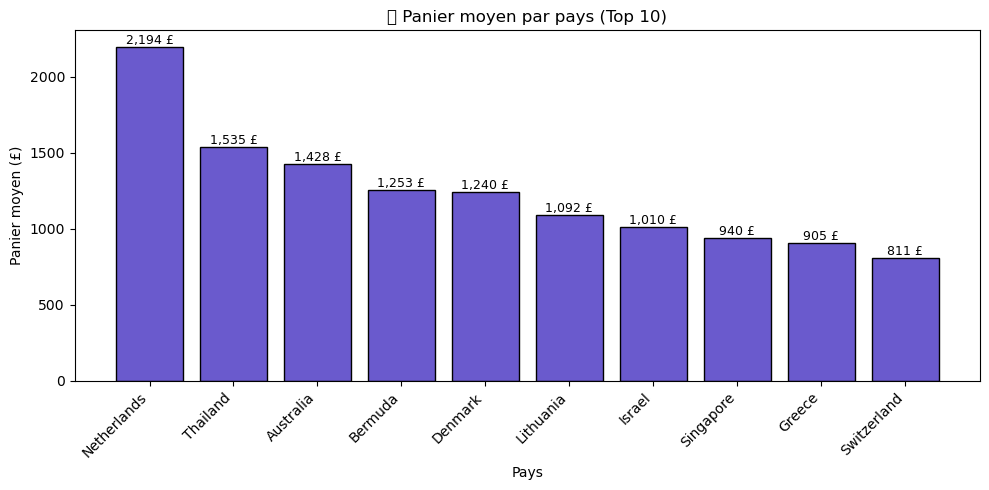

In [ ]:
# ============================================================
# 🛒 PANIER MOYEN PAR PAYS (TOP 10)
# ============================================================

# 1. Revenu total par commande
order_values = (
    df.groupby('Invoice')['TotalPrice']
      .sum()
      .reset_index(name='OrderValue')
)

# 2. Associer chaque commande à un pays
order_country = (
    df[['Invoice', 'Country']]
    .drop_duplicates()
    .merge(order_values, on='Invoice')
)

# 3. Panier moyen par pays (top 10)
country_avg = (
    order_country.groupby('Country')['OrderValue']
                 .mean()
                 .sort_values(ascending=False)
                 .head(10)
)

# 4. Graphique
plt.figure(figsize=(10,5))
bars = plt.bar(country_avg.index, country_avg.values, 
               color='slateblue', edgecolor='black')

plt.title("Panier moyen par pays (Top 10)")
plt.ylabel("Panier moyen (£)")
plt.xlabel("Pays")
plt.xticks(rotation=45, ha='right')

# ➤ Ajout des labels sur chaque barre
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:,.0f} £",   # format du panier moyen
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

plt.tight_layout()
plt.show()

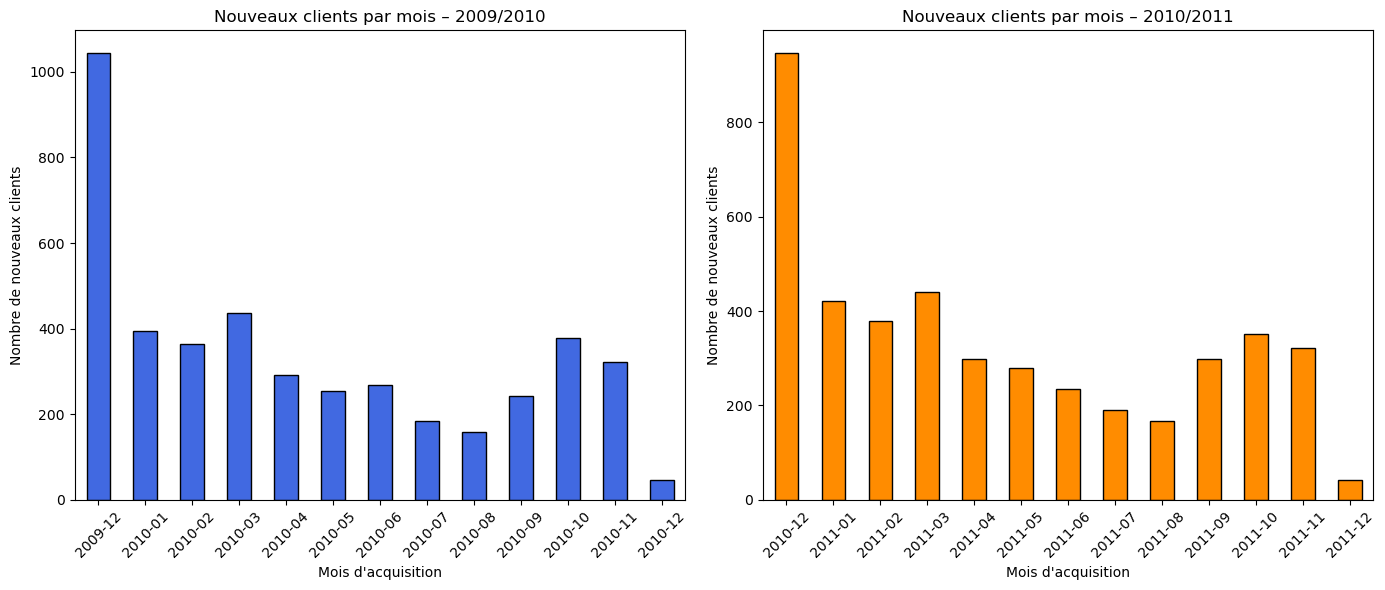

In [22]:
# ===============================================
# 📅 Première date d'achat pour 2009–2010
# ===============================================
first_purchase_09_10 = df_09_10.groupby('Customer ID')['InvoiceDate'].min()
cohort_09_10 = first_purchase_09_10.dt.to_period('M')
new_customers_09_10 = cohort_09_10.value_counts().sort_index()

# ===============================================
# 📅 Première date d'achat pour 2010–2011
# ===============================================
first_purchase_10_11 = df_10_11.groupby('Customer ID')['InvoiceDate'].min()
cohort_10_11 = first_purchase_10_11.dt.to_period('M')
new_customers_10_11 = cohort_10_11.value_counts().sort_index()

# ===============================================
# 📊 DOUBLE GRAPHIQUE
# ===============================================
plt.figure(figsize=(14,6))

# --- Graphe 1 : 2009–2010 ---
plt.subplot(1,2,1)
new_customers_09_10.plot(kind='bar', color='royalblue', edgecolor='black')
plt.title("Nouveaux clients par mois – 2009/2010")
plt.xlabel("Mois d'acquisition")
plt.ylabel("Nombre de nouveaux clients")
plt.xticks(rotation=45)

# --- Graphe 2 : 2010–2011 ---
plt.subplot(1,2,2)
new_customers_10_11.plot(kind='bar', color='darkorange', edgecolor='black')
plt.title("Nouveaux clients par mois – 2010/2011")
plt.xlabel("Mois d'acquisition")
plt.ylabel("Nombre de nouveaux clients")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

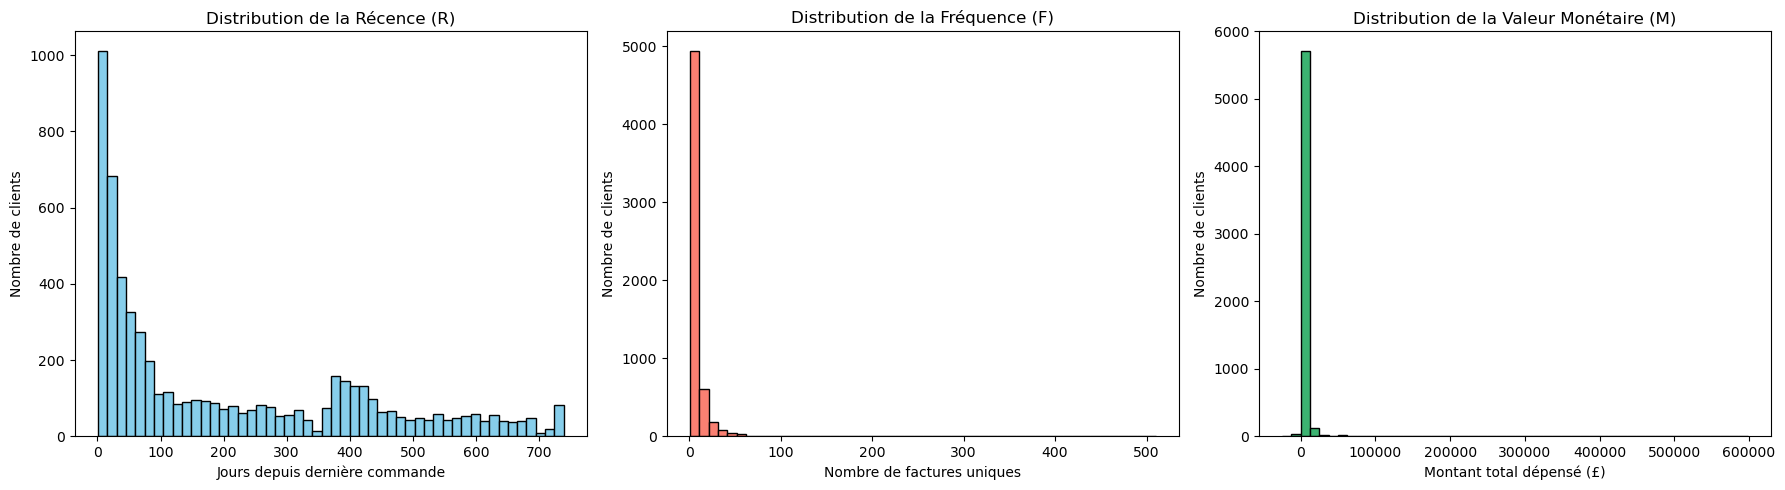

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,17,-64.68
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,5,4404.54
12350.0,310,1,334.40


In [24]:
# ============================================================
# 🧮 CALCUL RFM SUR LE DATASET GLOBAL (df)
# ============================================================

# Simuler une "date de référence" = jour après la dernière transaction
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Récence (en jours)
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})

# Renommer les colonnes correctement
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)



# ============================================================
# 📊 DISTRIBUTION R - F - M
# ============================================================

plt.figure(figsize=(18,5))

# --- Recency ---
plt.subplot(1,3,1)
plt.hist(rfm['Recency'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution de la Récence (R)")
plt.xlabel("Jours depuis dernière commande")
plt.ylabel("Nombre de clients")

# --- Frequency ---
plt.subplot(1,3,2)
plt.hist(rfm['Frequency'], bins=50, color='salmon', edgecolor='black')
plt.title("Distribution de la Fréquence (F)")
plt.xlabel("Nombre de factures uniques")
plt.ylabel("Nombre de clients")

# --- Monetary ---
plt.subplot(1,3,3)
plt.hist(rfm['Monetary'], bins=50, color='mediumseagreen', edgecolor='black')
plt.title("Distribution de la Valeur Monétaire (M)")
plt.xlabel("Montant total dépensé (£)")
plt.ylabel("Nombre de clients")

plt.tight_layout()
plt.show()

rfm.head()